# <center> SIFT detection 


***

# Import Data

In [1]:
from tqdm import tqdm
import cv2
import numpy as np
import scipy
#from scipy.misc import imread
import pickle
import random
import os
import matplotlib.pyplot as plt
import time
from lshash.lshash import LSHash
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.neighbors import KDTree
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

In [2]:
cd /Users/fatmamoalla/Desktop/OMA/S2/VIC/project/fashion-product-images-small

/Users/fatmamoalla/Desktop/OMA/S2/VIC/project/fashion-product-images-small


In [3]:
os.getcwd()

'/Users/fatmamoalla/Desktop/OMA/S2/VIC/project/fashion-product-images-small'

In [4]:

"""
data = glob.glob(str(os.getcwd())+"\images\images\*")
random.shuffle(data)
test_data = data[:500]
train_data = data[501:]
"""

test_data = np.loadtxt('TestSet.txt', delimiter = '\n')
train_data = np.loadtxt('NewData.txt', delimiter = '\n')
test_data = ['images/' + str(int(x))+ '.jpg' for x in test_data]
train_data = [ 'images/' + str(int(x))+ '.jpg' for x in train_data]

In [5]:
print(len(train_data))
print(len(test_data))

1207
10


In [5]:
cd fashion-product-images-small/

[Errno 2] No such file or directory: 'fashion-product-images-small/'
/Users/fatmamoalla/Desktop/OMA/S2/VIC/project/fashion-product-images-small


In [23]:
cd

/Users/fatmamoalla


In [6]:

styles = pd.read_csv('styles.csv',sep=',',error_bad_lines=False)
styles.head()

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [7]:
dic_classes = list(set(styles['subCategory']))
dic_classes.sort()
dic ={ classe: idx for (idx, classe) in enumerate(dic_classes)}
print(dic)

{'Accessories': 0, 'Apparel Set': 1, 'Bags': 2, 'Bath and Body': 3, 'Beauty Accessories': 4, 'Belts': 5, 'Bottomwear': 6, 'Cufflinks': 7, 'Dress': 8, 'Eyes': 9, 'Eyewear': 10, 'Flip Flops': 11, 'Fragrance': 12, 'Free Gifts': 13, 'Gloves': 14, 'Hair': 15, 'Headwear': 16, 'Home Furnishing': 17, 'Innerwear': 18, 'Jewellery': 19, 'Lips': 20, 'Loungewear and Nightwear': 21, 'Makeup': 22, 'Mufflers': 23, 'Nails': 24, 'Perfumes': 25, 'Sandal': 26, 'Saree': 27, 'Scarves': 28, 'Shoe Accessories': 29, 'Shoes': 30, 'Skin': 31, 'Skin Care': 32, 'Socks': 33, 'Sports Accessories': 34, 'Sports Equipment': 35, 'Stoles': 36, 'Ties': 37, 'Topwear': 38, 'Umbrellas': 39, 'Vouchers': 40, 'Wallets': 41, 'Watches': 42, 'Water Bottle': 43, 'Wristbands': 44}


# Build helpers functions

In [8]:


# Feature extractor
def extract_features(image_path, vector_size=200):
#def extract_features(image_path, vector_size=159):
    image = cv2.imread(image_path)
    sift = cv2.xfeatures2d.SIFT_create()
    # computing descriptors vector
    kps, dsc =sift.detectAndCompute(image,None)
    
    needed_size = (vector_size * 64)
    # Flatten all of them in one big vector - our feature vector
    if not(dsc is None):
        dsc = dsc.flatten()
    elif dsc is None:
        dsc = []
    if np.size(dsc) < needed_size:
        dsc = np.concatenate([dsc, np.zeros(needed_size - np.size(dsc))])
    
    return dsc

def batch_extractor(files, pickled_db_path="features.pck"):
    result = {}
    max_features =0
    for f in tqdm(files):
        name = f.split('/')[-1].lower()
        if name !='.ds_store':
            result[name] = extract_features(f)
            if np.shape(result[name])[0] > max_features:
                max_features = np.shape(result[name])[0]
                
    df = pd.DataFrame(result).T
    #x = df.values
    #pca = PCA(n_components=1200)
    #print('start PCA')
    #x_new = pca.fit_transform(x)
    #print(max(pca.explained_variance_ratio_))
    #new_df = pd.DataFrame(data = x_new, index = df.index)
    print('Save model')
    with open(pickled_db_path, 'wb') as fp:
        pickle.dump(df, fp)
    print('Saved all features =====')

In [9]:
from skimage.measure import compare_nrmse
from sklearn.metrics.pairwise import cosine_similarity

def find_img_cosine(path_img_1, path_img_2):
    img1 = cv2.imread(path_img_1)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img1 = np.reshape(img1,(len(img1)*len(img1[0]),1))
    img1 = [x[0] for x in img1]
    
    img2 = cv2.imread(path_img_2)
    img2 =  cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    img2 = np.reshape(img2,(len(img2)*len(img2[0]),1))
    img2 = [x[0] for x in img2]
    
    try:
        return [cosine_similarity([img1],[img2])[0][0]]
    except:
        print ("Different Dimensions, return empty array")
        return []

In [10]:
def show_cosine(neighbors,n=6):
    original = 'images/'+neighbors[0][0][1]
    cosines =[]
    for i in range(1,n):
        nearest ='images/'+neighbors[i][0][1]
        score = find_img_cosine(original, nearest)[0]
        cosines.append(score)
        print('distance with neighbor'+str(i),score)
    print('Mean cosine on image similarity',np.mean(cosines))

In [11]:
files = [os.path.join('images/', p) for p in sorted(os.listdir('images/'))]

In [12]:
len(files)

44441

# Buil matcher class

In [13]:

class Matcher(object):

    def __init__(self, pickled_db_path="features.pck"):
        with open(pickled_db_path,'rb') as fp:
            self.data = pickle.load(fp)
        self.hashtable = None
        self.kmeans = None
        
    def store_descriptors (self):
        ## Locality Sensitive Hashing
        # params
        k = 20 # hash size
        L = len(self.data)  # number of tables , self.data.keys
        d = 200*64 # Dimension of Feature vector
        self.hashtable = LSHash(hash_size=k, input_dim=d, num_hashtables=L)
        # LSH on all the images
        for img_path in tqdm(self.data.index):
            self.hashtable.index(self.data.loc[img_path], extra_data=img_path)
            
    def match(self, image_path, topn=3):
        print('start match')
        start = time.time()
        self.store_descriptors()
        end = time.time()
        print('Hash table built in', end-start)
        
        start = time.time()
        path = image_path.split('/')[1]
        dsc = self.data.loc[path]
        end = time.time()
        print('SIFT descriptor extract in',end -start )
        
        start = time.time()
        response = self.hashtable.query(dsc,num_results=topn, distance_func='hamming')
        end = time.time()
        print('Query done in', end -start)

        return response

In [14]:
def show_img(path):
    img = cv2.imread(path)
    plt.imshow(img)
    plt.show()
    
def run(train_data,test_data):
    images_path = 'images'
    files = train_data
    topn= 6
    sample = random.sample(test_data, 1)
    start = time.time()
    print(" Sift vocab ext= ==========================================")
    batch_extractor(train_data+test_data)
    end = time.time()
    ma = Matcher('features.pck')
    print('features constructed in',end-start)
    
    
    for s in sample:
        print ('Query image ==========================================')
        start = time.time()
        show_img(s)
        indexes  = ma.match(s, topn)
        end = time.time()
        print('Matched sample in',end-start) 
        print ('Result images ========================================')
        columns = 5
        rows = 1
        fig=plt.figure(figsize=(16, 16))
        print(len(indexes))
        for i in range(1,columns+1):  
            img = Image.open(images_path+'/'+indexes[i][0][1])
            fig.add_subplot(rows, columns, i)
            plt.imshow(img)
            plt.title('Nearest Image -'+str(i))
        plt.show()
    
    show_cosine(indexes,n=6)
    
    return indexes
        

            

# Run the matcher on all the images

- It takes 7 min to build the histogram vocabulary for the whole dataset

  1%|          | 12/1217 [00:00<00:10, 118.58it/s]

 Sift vocab ext= ==========================================


100%|██████████| 1217/1217 [00:07<00:00, 152.24it/s]


Save model
Saved all features =====
features constructed in 8.773576021194458
Query image ==========================================


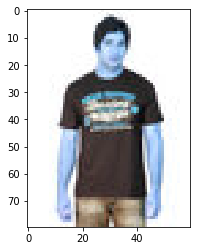

start match


100%|██████████| 1217/1217 [05:42<00:00,  4.88it/s]


Hash table built in 357.8854789733887
SIFT descriptor extract in 0.0004191398620605469
Query done in 3.8701162338256836
Matched sample in 361.9026381969452
Result images ========================================
6


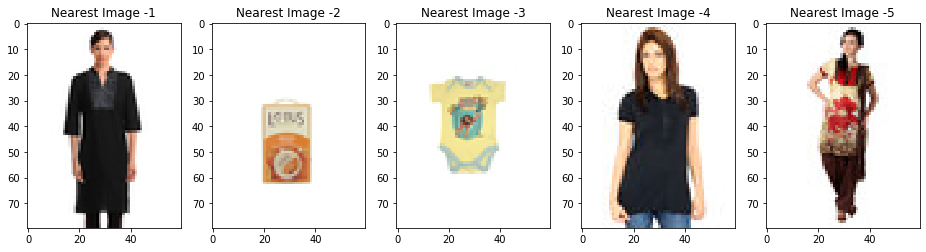

distance with neighbor1 0.9462753344653891
distance with neighbor2 0.9253761180512443
distance with neighbor3 0.9195809046292515
distance with neighbor4 0.9542504338734656
distance with neighbor5 0.9268435650843351
Mean cosine on image similarity 0.9344652712207371


In [16]:
# First Example
neighbors0 = run(train_data,test_data)

  2%|▏         | 19/1217 [00:00<00:06, 181.33it/s]

 Sift vocab ext= ==========================================


100%|██████████| 1217/1217 [00:06<00:00, 190.95it/s]


Save model
Saved all features =====
features constructed in 7.374664068222046
Query image ==========================================


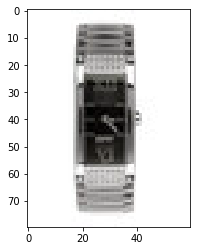

start match


100%|██████████| 1217/1217 [11:03<00:00,  3.34it/s]


Hash table built in 687.9969170093536
SIFT descriptor extract in 0.0003829002380371094
Query done in 6.352337121963501
Matched sample in 694.7627267837524
Result images ========================================
6


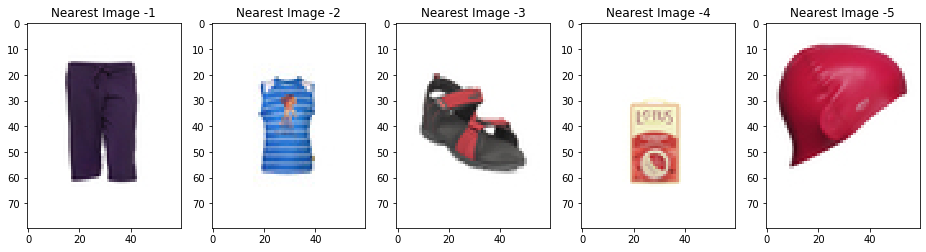

distance with neighbor1 0.9553553849683901
distance with neighbor2 0.9744767091826066
distance with neighbor3 0.9499915751308047
distance with neighbor4 0.9589943804017023
distance with neighbor5 0.915402085866299
Mean cosine on image similarity 0.9508440271099605


In [23]:
neighbors1 = run(train_data,test_data)

  1%|▏         | 18/1217 [00:00<00:06, 176.77it/s]

 Sift vocab ext= ==========================================


100%|██████████| 1217/1217 [00:05<00:00, 232.81it/s]


Save model
Saved all features =====
features constructed in 5.668533086776733
Query image ==========================================


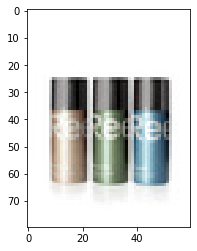

start match


100%|██████████| 1217/1217 [07:43<00:00,  2.91it/s]


Hash table built in 476.83315086364746
SIFT descriptor extract in 0.0003600120544433594
Query done in 5.062041997909546
Matched sample in 482.12039613723755
Result images ========================================
6


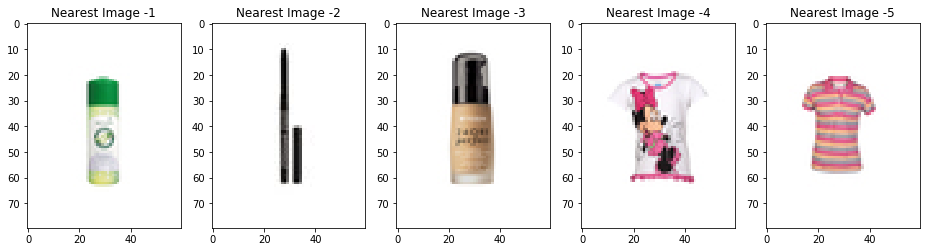

distance with neighbor1 0.9545246344944919
distance with neighbor2 0.942942929231454
distance with neighbor3 0.9479321880232168
distance with neighbor4 0.9571541399555414
distance with neighbor5 0.9640751760428485
Mean cosine on image similarity 0.9533258135495105


In [19]:
neighbors2 = run(train_data,test_data)